In [1]:
import os
import pandas as pd
import json
import folium
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO



# Question 1: European Union unemployment statistics

First, we import the data and create an overlay map:

In [2]:
eu_topo_path = r'europe.topojson.json'
topo_json_data = json.load(open(eu_topo_path))

In [3]:
m_eu = folium.Map([50,8], tiles='cartodbpositron', zoom_start=3)
folium.TopoJson(topo_json_data,"objects.europe").add_to(m_eu)
m_eu

List of country names in the map overlay. We will use this a few cells later.

In [4]:
TOPOnames = pd.DataFrame(topo_json_data['objects']['europe']['geometries'])['properties'].apply(lambda x: x["NAME"])
TOPOnames.name='TOPOname'

Now we read the data and do some cleaning up and extract some useful stuff out of it.

In [5]:
df1=pd.read_csv("tipsun20.tsv",delimiter='\t')
df1["id"]=df1["sex,age,unit,geo\\time"].apply(lambda x: x.split(",")[-1])
df1["age"]=df1["sex,age,unit,geo\\time"].apply(lambda x: x.split(",")[1])
df1.columns = [x.strip() for x in df1.columns]

Now we need a mapping from country id to country name to replace the country ids that we have in our unemployment dataset. These names were extracted from the eustat website itself (no idea why they themselves haven't put it in any json or tsv file though). It is worth noting that these 84 rows that we have actually belong to 84/3 = 28 countries; each country is repeated thrice (once for TOTAL among all ages, once for 25-74, once for under 25).

In [6]:
labels2names={
"BE":"Belgium",
"BG":"Bulgaria",
"CZ":"Czech Republic",
"DK":"Denmark",
"DE":"Germany",
"EE":"Estonia",
"IE":"Ireland",
"EL":"Greece",
"ES":"Spain",
"FR":"France",
"HR":"Croatia",
"IT":"Italy",
"CY":"Cyprus",
"LV":"Latvia",
"LT":"Lithuania",
"LU":"Luxembourg",
"HU":"Hungary",
"MT":"Malta",
"NL":"Netherlands",
"AT":"Austria",
"PL":"Poland",
"PT":"Portugal",
"RO":"Romania",
"SI":"Slovenia",
"SK":"Slovakia",
"FI":"Finland",
"SE":"Sweden",
"UK":"United Kingdom"}

df1["name"]=df1["id"].replace(labels2names)
print(df1.shape)
df1.head()

(84, 26)


,"sex,age,unit,geo\time",1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,id,age,name
0,"T,TOTAL,PC_ACT,AT",4.2,4.7,4.7,4.7,4.2,3.9,4.0,4.4,4.8 i,...,4.8,4.6,4.9,5.4,5.6,5.7,6.0,AT,TOTAL,Austria
1,"T,TOTAL,PC_ACT,BE",9.7,9.5,9.2,9.3,8.4,6.9,6.6,7.5,8.2,...,8.3,7.2,7.6,8.4,8.5,8.5,7.8,BE,TOTAL,Belgium
2,"T,TOTAL,PC_ACT,BG",:,:,:,:,:,16.4,19.6,18.2,13.7,...,10.3 i,11.3,12.3,13.0,11.4,9.2,7.6,BG,TOTAL,Bulgaria
3,"T,TOTAL,PC_ACT,CY",:,:,:,:,:,4.8,3.9,3.5,4.1,...,6.3,7.9,11.9,15.9,16.1,15.0,13.0,CY,TOTAL,Cyprus
4,"T,TOTAL,PC_ACT,CZ",4.0,3.9,4.8,6.5,8.7,8.8,8.1,7.3,7.8,...,7.3,6.7,7.0,7.0,6.1,5.1,4.0,CZ,TOTAL,Czech Republic


In [7]:
df1.loc[df1["age"]=="TOTAL"][['id', '2016']].head()

,id,2016
0,AT,6.0
1,BE,7.8
2,BG,7.6
3,CY,13.0
4,CZ,4.0


Now, to be sure that all the countries in the unemployment dataset have the same names on the map (so that they match and are shown), we 

In [8]:
TOPOnames.name="TOPOnames"

In [9]:
df2=df1[df1['age']=='TOTAL'].merge(pd.DataFrame(TOPOnames),left_on="name",right_on="TOPOnames",how='outer')
df2['age'] = ['TOTAL']*df2.shape[0]
#df2['2016'] = df2['2016'].fillna(0)
#df2 = df2.dropna()

Now, if there are no name discrepancies, after dropping the null values (countries on the map that don't exist in the unemployment data), we should have exactly 28 countries (i.e. rows) in the dataframe, and here it is.

In [10]:
df2.dropna().shape

(28, 27)

All that's left is to plot the values. We chose the purple-red colour palette because null values will be shown as white (something pretty close to white but not exactly) and we felt that this palette provided greater visual separation from white compared to the others. Also, we've chosen the border colours to be black to further increase the contrast.

In [11]:
m_eu = folium.Map([50,8], tiles='cartodbpositron', zoom_start=3)


m_eu.choropleth(geo_data=topo_json_data, topojson='objects.europe',
                  data=df1, columns=['name', '2016'],
                  fill_opacity=0.7,
                  key_on="feature.properties.NAME",
                  line_color='black', fill_color='PuRd',
                  highlight=False
                 )
m_eu


As you can see above, data is missing for non-EU member countries (such as Switzerland or several Balkan states), and among those with data present, we can see that the UK, Germany, Netherlands, Denmark, Austria, Czech Republic, Hungary, and Estonia fall into the lowest group (which is below 14%), while Greece and Spain have pretty high unemployment rates.

# Question 2: Swiss unemployment statistics
## Step 1: Getting the canton map
First of all, we create a map of cantons, same as for the eustat dataset.

In [12]:
ch_topo_path = r'ch-cantons.topojson.json'
topo_json_data = json.load(open(ch_topo_path))

In [13]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_data,"objects.cantons").add_to(m_ch)
m_ch

## Step 2: Getting the data out of the CSV file
In the following cell, we get our data out of the csv file we've downloaded from amstat, and then based on what we know about the rates, we calculate the active populations.

In the HW description, it is said that the rate, known as "taux de chômeurs" in our csv, is the number of people looking for a job (which is "demandeurs d'emploi" in French), divided by the active population. *This does not make sense in our data*. We believe that this rate is actually the number of unemployed people divided by the total active population. Why? Because if we calculate the active population of each canton as $\frac{number\ of\ jobseekers}{unemployment\ rate/100}$, then the sum of active population over all the cantons will be ~6,800,000 people, which is much more than the active population of Switzerland. However, if we assume it to be the ratio of unemployed jobseekers to the active population, then the resulting total active population will be ~4,500,000, which is much closer to the 4,800,000 that we know as the active population of Switzerland. The said information about Swiss active population can be found here: https://fred.stlouisfed.org/series/LFAC74TTCHQ647N

Therefore, we have calculated the active population for each canton/nationality as $\frac{number\ of\ unemployed}{unemployment\ rate/100}$. We also drop the "total" row.

In [14]:
def read_data_amstat(filename):
    with open(filename, 'r',encoding='utf-16') as f:
        read_data = list(f.read().replace('""""','"" ""'))
    #
    in_quote=False
    changed=0
    for i in range(len(read_data)):
        if read_data[i] =='"' and read_data[i+1]=='"' and read_data[i-1]!='"':
            in_quote= not in_quote
        if read_data[i]==',' and (not in_quote):
            read_data[i]='#'
            changed+=1

    matrix=list(map(lambda x: x.split("#"),''.join(read_data).replace('"','').split('\n')))
    PDdata=pd.DataFrame(matrix[2:-1])
    PDdata.columns=matrix[:2]
    PDdata.drop("Total",axis=1,inplace=True)
    return PDdata

PDdata = read_data_amstat('unemployment_with_youth.csv')
PDdata.columns=["Canton","Nationalité","stuff","Unemployment rate","Youth unemployment rate","Number of unemployed","Number of youth unemployed","Number of jobseekers","Non-unemployed jobseekers"]
PDdata.drop("stuff",inplace=True,axis=1)
PDdata.replace({"...": np.nan},inplace=True)
#PDdata.drop(52,inplace=True)

/Users/odor/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


In [15]:
PDdata = PDdata.drop(52)
PDdata["Unemployment rate"]=pd.to_numeric(PDdata["Unemployment rate"])
PDdata["Youth unemployment rate"]=pd.to_numeric(PDdata["Youth unemployment rate"])

PDdata["Number of unemployed"]=pd.to_numeric(PDdata["Number of unemployed"].apply(lambda x: x.replace("'","")))
PDdata["Number of jobseekers"]=pd.to_numeric(PDdata["Number of jobseekers"].apply(lambda x: x.replace("'","")))
PDdata["Non-unemployed jobseekers"]=pd.to_numeric(PDdata["Non-unemployed jobseekers"].apply(lambda x: x.replace("'","")))
PDdata["Number of youth unemployed"]=pd.to_numeric(PDdata["Number of youth unemployed"].apply(lambda x: x.replace("'","")))

PDdata["Number of active people"]=PDdata["Number of unemployed"]/(PDdata["Unemployment rate"]/100)
PDdata["Number of active youth"]=PDdata["Number of youth unemployed"]/(PDdata["Youth unemployment rate"]/100)

In [16]:
PDdata.head()

,Canton,Nationalité,Unemployment rate,Youth unemployment rate,Number of unemployed,Number of youth unemployed,Number of jobseekers,Non-unemployed jobseekers,Number of active people,Number of active youth
0,Zurich,Etrangers,5.3,5.8,12111,1015,15384,3273,228509.433962,17500.000000
1,Zurich,Suisses,2.5,3.2,15114,2405,18772,3658,604560.000000,75156.250000
2,Berne,Etrangers,5.5,7.7,4900,597,6859,1959,89090.909091,7753.246753
3,Berne,Suisses,1.8,2.2,8758,1406,11526,2768,486555.555556,63909.090909
4,Lucerne,Etrangers,3.9,4.7,1593,217,2902,1309,40846.153846,4617.021277


In [17]:
PDdata["Number of active people"].sum()

4511935.186398289

The canton names in the map JSON aren't the same as the names in the amstat dataset, but they are both sorted in the same order. Therefore, to be able to match the names, we create a dataframe and join the JSON file names with the amstat names on their indices, and use this later to match values we have calculated with their on-map locations. You can check below that the names are actually correctly matched using this method.

In [18]:
names=pd.DataFrame(list(map(lambda x: x['properties']['name'],topo_json_data["objects"]["cantons"]['geometries'])))
names.columns=["map_name"]
data_names = pd.DataFrame(PDdata['Canton'].unique())

In [19]:
data_names = data_names.rename(columns={0:"Canton"})
data_names_df = data_names.merge(names,left_index=True, right_index=True)
data_names_df.head()

,Canton,map_name
0,Zurich,Zürich
1,Berne,Bern/Berne
2,Lucerne,Luzern
3,Uri,Uri
4,Schwyz,Schwyz


## Step 3: Calculating the rates and visualising
Now we will calculate unemployment rates and jobseeking rates (in percents) for all the cantons (for all nationalities and ages).

In [20]:
aggregated_df = PDdata[['Canton', 'Number of unemployed', 'Number of jobseekers', 'Non-unemployed jobseekers', 'Number of active people']].groupby('Canton').sum()
aggregated_df['unemployment rate'] = 100*aggregated_df['Number of unemployed']/aggregated_df['Number of active people']
aggregated_df['jobseeking rate'] = 100*aggregated_df['Number of jobseekers']/aggregated_df['Number of active people']
aggregated_df = aggregated_df.reset_index().rename(columns={'index':'Canton'})
aggregated_df.head()

,Canton,Number of unemployed,Number of jobseekers,Non-unemployed jobseekers,Number of active people,unemployment rate,jobseeking rate
0,Appenzell Rhodes-Extérieures,523,866,343,29836.134454,1.752908,2.902521
1,Appenzell Rhodes-Intérieures,62,102,40,8950.000000,0.692737,1.139665
2,Argovie,10684,15145,4461,360785.714286,2.961315,4.197783
3,Berne,13658,18385,4727,575646.464646,2.372637,3.193801
4,Bâle-Campagne,4082,5540,1458,146250.000000,2.791111,3.788034


Now we do the matching on names:

In [21]:
aggregated_df=aggregated_df.merge(data_names_df, left_on="Canton", right_on="Canton")

The following is the map for **unemployment rate** (i.e. only considering people without a job) across Swiss cantons. As you can see, Geneva and Neuchatel have the highest unemployment rates. Our own dear Lausanne is pretty high on the scale. In general, it appears that the French-speaking cantons possess higher unemployment rates. The central and central-eastern cantons have the lowest unemployment rates. In the German-speaking cantons, Zurich seems to possess a relatively high unemployment rate.

In [22]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)


m_ch.choropleth(geo_data=topo_json_data, topojson='objects.cantons',
                  data=aggregated_df, columns=["map_name", "unemployment rate"],
                  fill_opacity=0.7,
                  key_on="feature.properties.name",
                  line_color='black', fill_color='PuRd',
                  highlight=False
                 )
m_ch


And the following is the map for jobseeking rate: i.e. the number of jobseekers, both employed and unemployed, divided by the canton's active population. As we expect, the values are higher than the unemployment rates because this also includes employed people who are looking for another job. Again, French-speaking cantons are at the top and again the central cantons possess the lowest rates, which probably indicates a relatively high level of job satisfaction, and probably also the existence of traditional jobs and lower immigration (as opposed to the cantons with greater levels of immigration - traditional jobs are meaningless for immigrants).

In [23]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)


m_ch.choropleth(geo_data=topo_json_data, topojson='objects.cantons',
                  data=aggregated_df, columns=["map_name", "jobseeking rate"],
                  fill_opacity=0.7,
                  key_on="feature.properties.name",
                  line_color='black', fill_color='PuRd',
                  highlight=False
                 )
m_ch


# Question 3: Swiss people, Foreigners and Youth
Now we will show the difference between unemployment rates among originally Swiss people and foreigners and also divisions based on young people.

In [24]:
Suisse = PDdata[PDdata['Nationalité']=='Suisses'][['Canton','Unemployment rate']]

In [25]:
Strangers = PDdata[PDdata['Nationalité']=='Etrangers'][['Canton','Unemployment rate']]

In [26]:
Suisse = Suisse.merge(data_names_df, left_on="Canton", right_on="Canton")
Strangers = Strangers.merge(data_names_df, left_on="Canton", right_on="Canton")

We make two choropleths of Suisse people and strangers unemployment rate. For the two maps to be comparable we use the same color scale for two choropleths. Doing so we see that the difference of rates for Suisse people is not so distinguishable this is because that the rate for strangers is generally higher than for Suisse people. We can see this difference clearly by comparing the two choropleth maps. The first is for Swiss people and the second for foreigners.

In [27]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)
m_ch.choropleth(geo_data=topo_json_data, topojson="objects.cantons",
                data = Suisse,
                columns=['map_name', 'Unemployment rate'], 
                key_on="feature.properties.name",
                fill_color='PuRd', fill_opacity=0.6,
                line_color='black', highlight=True,
                threshold_scale=[0, 1.8, 3.6, 5.4, 7.2, 9],
                legend_name='Percentage Unemployment for Suisse people  (%)')
m_ch

In [28]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)
m_ch.choropleth(geo_data=topo_json_data, topojson="objects.cantons",
                data = Strangers,
                columns=['map_name', 'Unemployment rate'], 
                key_on="feature.properties.name",
                fill_color='PuRd', fill_opacity=0.6,
                line_color='black', highlight=True,
                threshold_scale=[0, 1.8, 3.6, 5.4, 7.2, 9],
                legend_name='Percentage Unemployment for Strangers  (%)')
m_ch

For visualizing the difference of Suisse and non-Suisse unemployment rate we can also compute the difference of these two values for each canton and show the difference in one choropleth.

In [29]:
Strangers = Strangers.reset_index(drop=True)
Suisse = Suisse.reset_index(drop=True)
Differ = Suisse[['Canton','map_name']]
Differ['difference'] = Strangers['Unemployment rate']-Suisse['Unemployment rate']

In the map below we see that the highest difference is for canton Jura while we see that foreigners job seekers are highly welcome in Geneva. This can be due to the presence of united nations in geneva which has a lot of non Suisse employees.

In [30]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)
m_ch.choropleth(geo_data=topo_json_data, topojson="objects.cantons",
                data = Differ,
                columns=['map_name', 'difference'], 
                key_on="feature.properties.name",
                fill_color='PuRd', fill_opacity=0.6,
                line_color='black', highlight=True,
                legend_name='Difference of Unemployment rate (Stranger-Suisse)   (%)')
m_ch

The amstat website does not allow us to obtain the attributes nationality and age group in the same time for the data set of unemployment rates. Alternatively we tried to download the data set that contained the number of unemployed and jobseekers within each group of age and nationality. However, whith this approach we still cannot get the rate for age groups within a nationality since for obtining the rate we need both the number of unemployed and the number of active people within a group while the data set of numbers doesn't give us the number of active people. For example we can obtain the number of unemployed People who are Swiss and are in age group 15-24 years but we cannot obtain the number of active people in such group hence we cannot calculate the rate.

As an alternative solution we decided to use the data set that has the youth Unemployment rate and also the number of youth people who are unemployed. Having these two numbers we can calculate the number of active youth people and also the number of active non-youth people and hence we can calculate the rate for these two groups. Therefore we would have 2 age groups: Youth and Non-Youth.

In [31]:
PDdata['non youth unemployment rate'] = (PDdata['Number of unemployed']-PDdata['Number of youth unemployed'])*100/(PDdata['Number of active people']-PDdata['Number of active youth'])

In [32]:
PDdata_canton_ind = PDdata.set_index('Canton')

In the bar plot below we can see the unemployment rate for each age group of Swiss people and strangers in each Canton. As we can see for some cantons there is missing data for strangers. The reason is that for some of the cantons for strangers the data for youth unemployment rate was missing and since the rate of non-youth is also calculated using the youth active population and hence the youth rate, the rate for non-youth is missing as well.

Looking at the bar chart, we can see that for most of the cantons youth unemployment rate is higher than the non-youth unemployment rate for both Swiss and strangers. Two intersting point is the unemployment rate for strangers in Geneva and Vaud Cantons. We see that for these two cantons the youth unemployment rate is less than non-youth rate and this difference is quiete noticeable. The reason for Geneva is probably the presence of United Nations. For canton Vaud it is probably because of EPFL where a lot of international students graduate each year and probably they can successfully find a job in Lausanne after their studies.

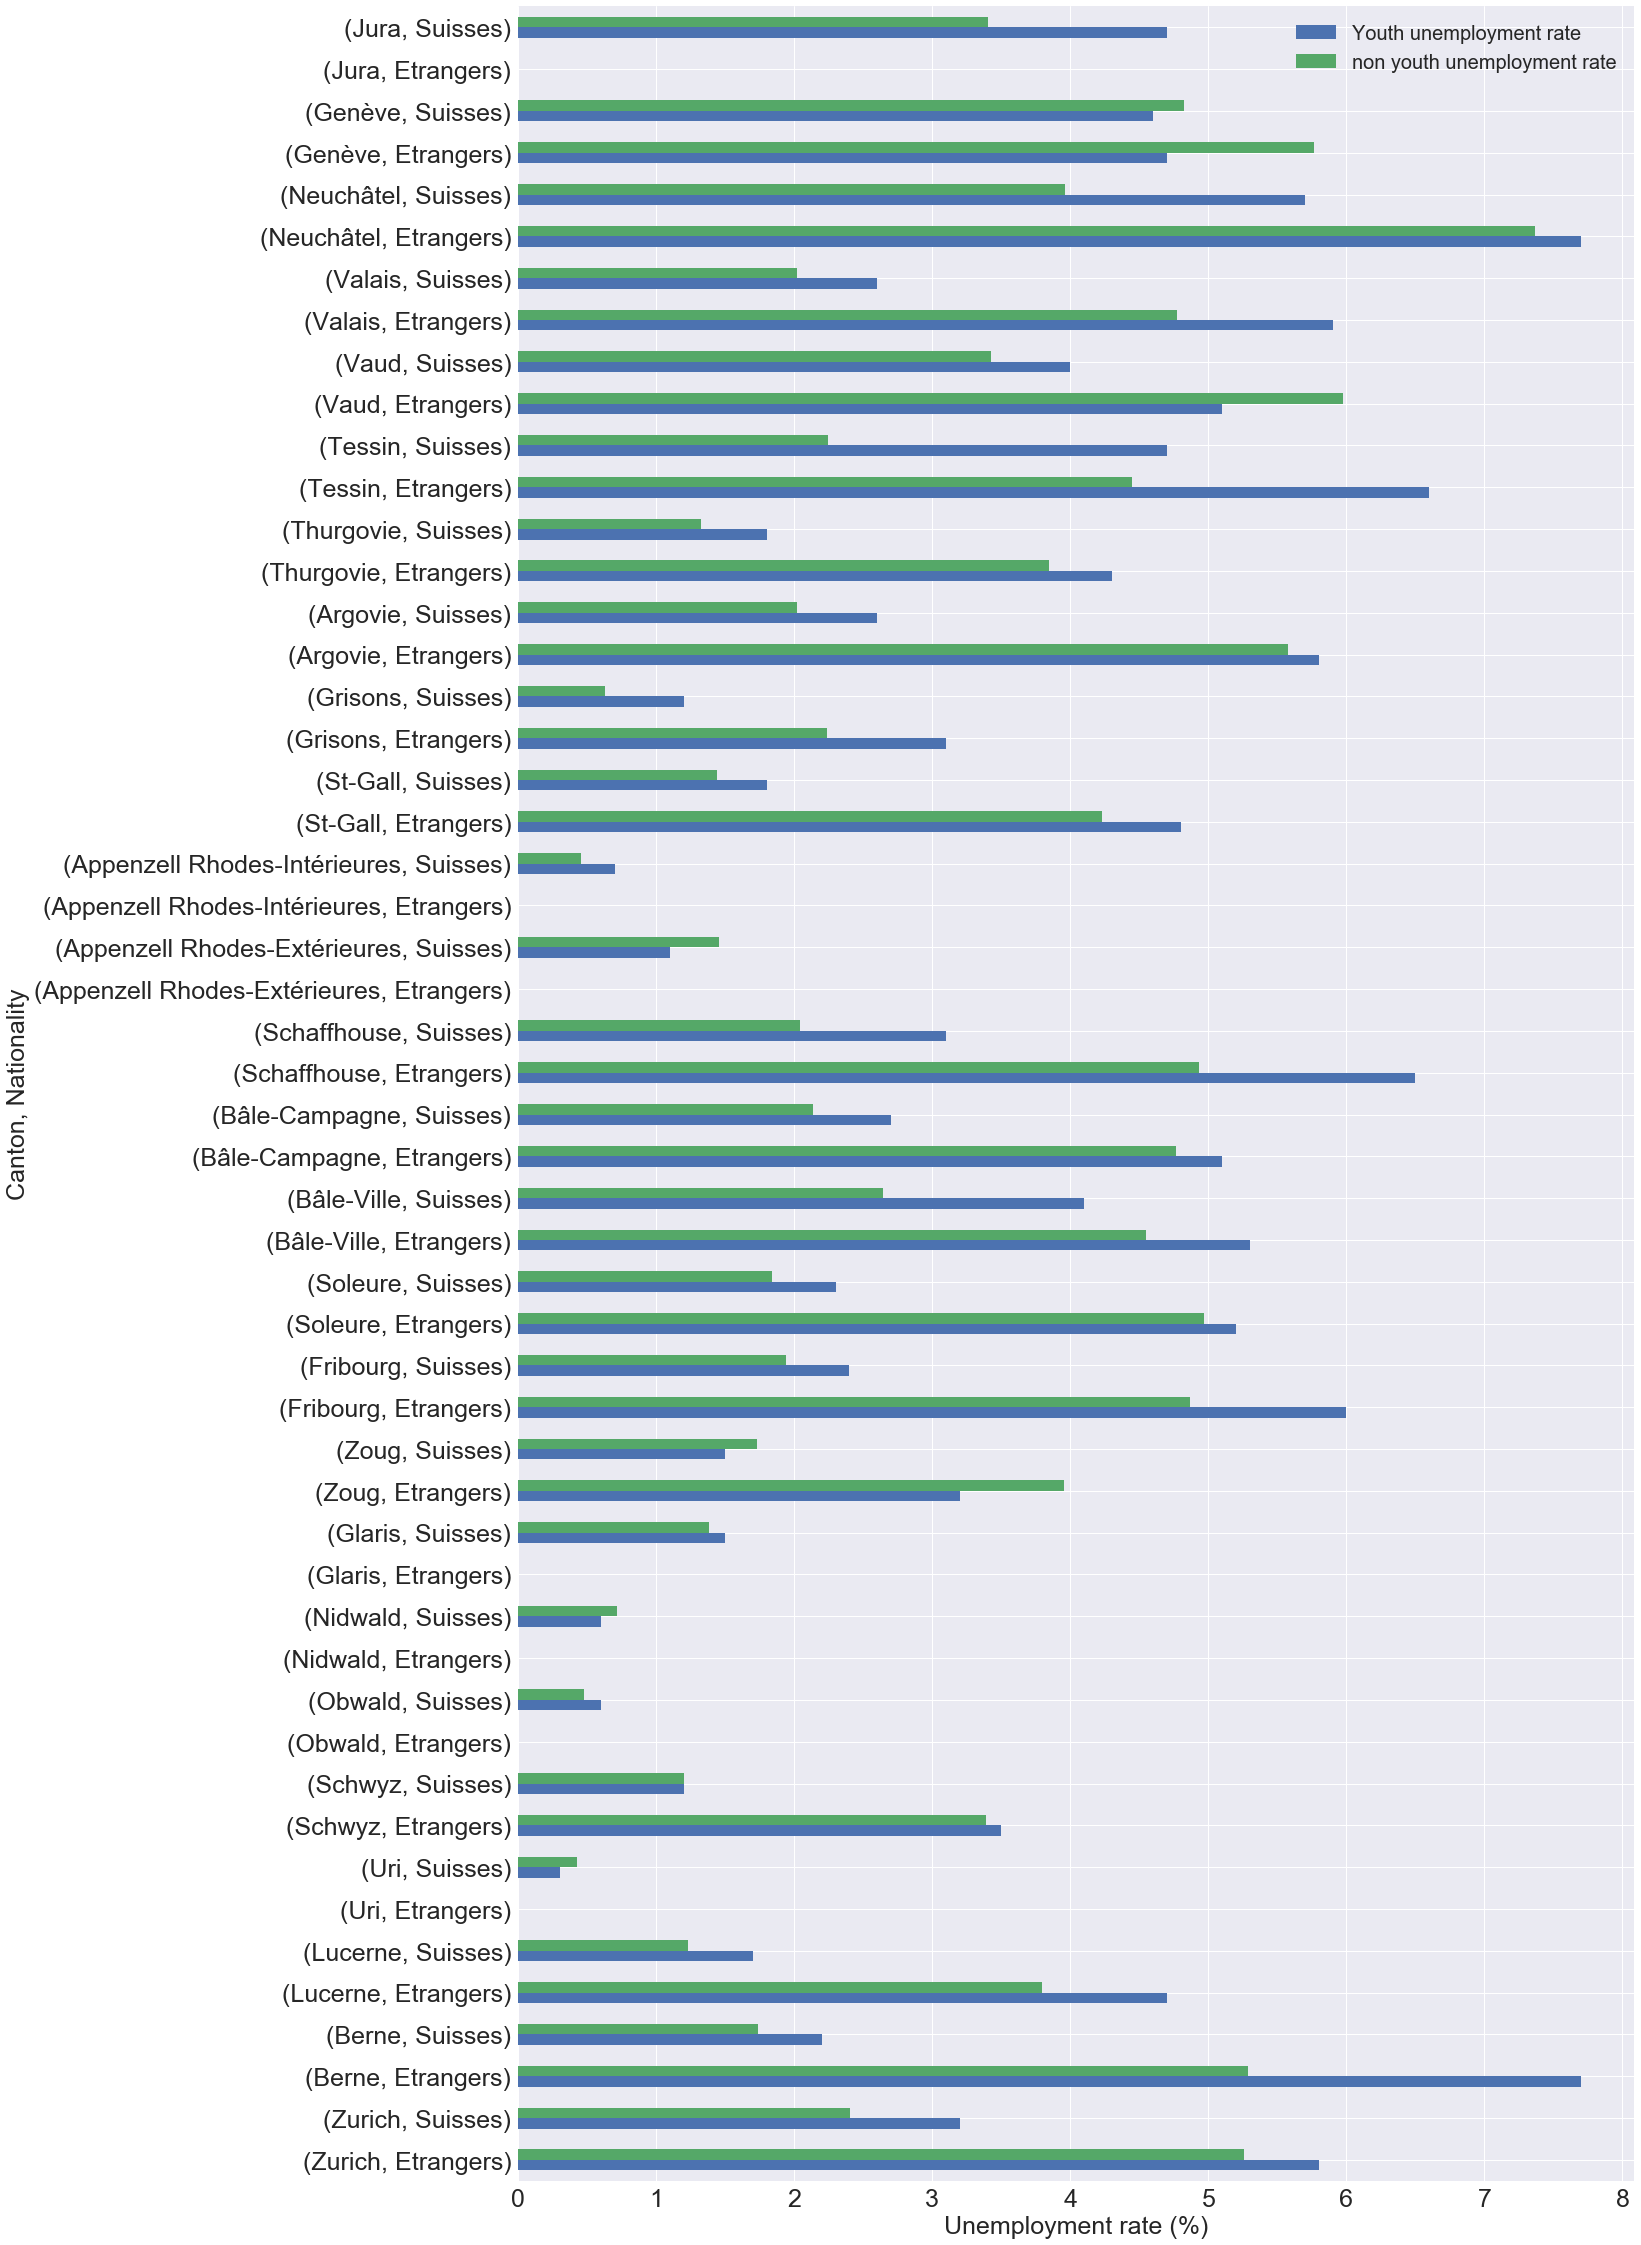

In [33]:
plt.figure(figsize=(20,10))
#sns.barplot(x="Canton", y=["Youth unemployment rate", "non youth unemployment rate"], hue="Nationalité", data=PDdata)
PDdata.plot(x=["Canton", "Nationalité"] , y=["Youth unemployment rate", "non youth unemployment rate"], kind='barh',figsize=(20,40))
plt.xticks(rotation = 0, fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(fontsize=20)
plt.xlabel('Unemployment rate (%)', fontsize = 25)
plt.ylabel('Canton, Nationality', fontsize = 25);

# Question 4: Comparison of unemployment across the Röstigraben
Now we will calculate a rough estimate of unemployment rates in each region of the Röstigraben. Since some of the cantons are present in several areas, we will make the following assumptions:
* Valais is assumed to be entirely in the French part. No disrespect to those living in Upper Wallis.
* Fribourg is, again, considered only in the French part.
We will use another csv file extracted from the amstat website, with both cantons and language regions.

In [34]:
LingRegData = read_data_amstat('rostigraben_data.csv')

LingRegData.columns=["Linguistic Region", "Canton","stuff","Unemployment rate","Number of unemployed"]
LingRegData.drop("stuff",inplace=True,axis=1)
LingRegData.replace({"...": np.nan},inplace=True)
LingRegData.drop(26,inplace=True)

LingRegData["Unemployment rate"]=pd.to_numeric(LingRegData["Unemployment rate"])
LingRegData["Number of unemployed"]=pd.to_numeric(LingRegData["Number of unemployed"].apply(lambda x: x.replace("'","")))

/Users/odor/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


In [35]:
LingRegData['Linguistic Region'] = LingRegData['Linguistic Region'].replace(to_replace='Suisse romande et Tessin', value='Suisse romande')
LingRegData.loc[LingRegData['Canton'] == 'Tessin', 'Linguistic Region'] = 'Tessin'

LingRegData["Number of active people"]=LingRegData["Number of unemployed"]/(LingRegData["Unemployment rate"]/100)

In [36]:
agg_on_region = LingRegData.groupby('Linguistic Region').sum()
agg_on_region['Region unemployment'] = 100*agg_on_region['Number of unemployed'] / agg_on_region['Number of active people']
agg_on_region = agg_on_region.reset_index()
LingRegData = LingRegData.merge(agg_on_region, left_on='Linguistic Region', right_on='Linguistic Region')
LingRegData = LingRegData.merge(data_names_df, left_on='Canton', right_on='Canton')

In [37]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)
m_ch.choropleth(geo_data=topo_json_data, topojson="objects.cantons",
                data = LingRegData,
                columns=['map_name', 'Region unemployment'], 
                key_on="feature.properties.name",
                fill_color='PuRd', fill_opacity=0.6,
                line_color='black', highlight=True,
                legend_name='Linguistic Region unemployment rates')
m_ch

As you can see, the French-speaking part > Italian-speaking part > German-speaking part.